In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb


In [4]:
import wandb
wandb.init(project="bert-training")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
!pip install transformers datasets torch scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load Jigsaw/Conversation AI dataset
jigsaw_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')  # Training data from Jigsaw
jigsaw_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')    # Test data from Jigsaw

In [9]:
jigsaw_train_df['label'] = jigsaw_train_df['toxic'].astype(int)
jigsaw_train_df = jigsaw_train_df[['comment_text', 'label']]

In [10]:
train_texts = jigsaw_train_df['comment_text'].tolist()
train_labels = jigsaw_train_df['label'].tolist()
test_texts = jigsaw_test_df['comment_text'].tolist()

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
def tokenize_function(examples):
    return tokenizer(examples['comment_text'], padding="max_length", truncation=True)

In [14]:
train_dataset = Dataset.from_dict({'comment_text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'comment_text': test_texts})

In [15]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/153164 [00:00<?, ? examples/s]

In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=4,   # batch size for training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=250,                # number of warmup steps for learning rate scheduler
    weight_decay=0.5,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch",     # evaluate after each epoch
    save_steps=5000,
    save_total_limit=2,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
)

In [19]:
# Train the model
team7Model = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,0.420700,No log


In [26]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/bert-toxic-model')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/bert-toxic-model')

('/content/drive/MyDrive/Colab Notebooks/bert-toxic-model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/bert-toxic-model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/bert-toxic-model/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/bert-toxic-model/added_tokens.json')

In [27]:
print("Model and tokenizer saved!")

Model and tokenizer saved!


In [43]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # number of training epochs
    per_device_train_batch_size=4,   # batch size for training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=250,                # number of warmup steps for learning rate scheduler
    weight_decay=0.5,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch",     # evaluate after each epoch
    save_steps=5000,
    save_total_limit=2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [44]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
)

In [45]:
# Train the model
team7Model_Version1 = trainer.train()

Epoch,Training Loss,Validation Loss
1,0.405700,No log
2,0.181500,No log


In [100]:
from transformers import TrainerCallback

In [101]:
# Custom callback to log validation metrics
class LogValidationLossCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model, tokenizer, logs=None, **kwargs):
        # Log validation loss after each epoch
        print(f"Validation Loss at epoch {state.epoch}: {logs.get('eval_loss')}")

In [112]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=4,   # batch size for training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=250,                # number of warmup steps for learning rate scheduler
    weight_decay=0.5,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,                # print logs every 50 steps
    evaluation_strategy="epoch",     # evaluate after each epoch
    save_strategy="epoch",           # save after each epoch
    load_best_model_at_end=True,     # load the best model when finished training
    metric_for_best_model="eval_loss",  # Use eval_loss for the best model selection
    greater_is_better=False,         # For loss-based metrics, lower is better
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [117]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
        "precision": precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average="binary")[0],
        "recall": precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average="binary")[1],
        "f1": precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average="binary")[2],
    },
    callbacks=[LogValidationLossCallback()]  # Custom callback to log validation loss
)

Testting the trained model.

In [84]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [86]:
# Load model and tokenizer
model_name = "/content/drive/MyDrive/Colab Notebooks/bert-toxic-model-version1"  # Pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [128]:
# Input text
text = """I love you"""

In [129]:
# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

In [133]:
# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [97]:
# Convert logits to probabilities
logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)

In [98]:
# Print results
labels = ["Non-Toxic", "Toxic"]  # Adjust based on the model
predictions = {labels[i]: float(probs[0][i]) for i in range(len(labels))}

In [99]:
print("Predictions:", predictions)

Predictions: {'Non-Toxic': 0.9970520734786987, 'Toxic': 0.002947949105873704}


Data Visualization Graphs

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

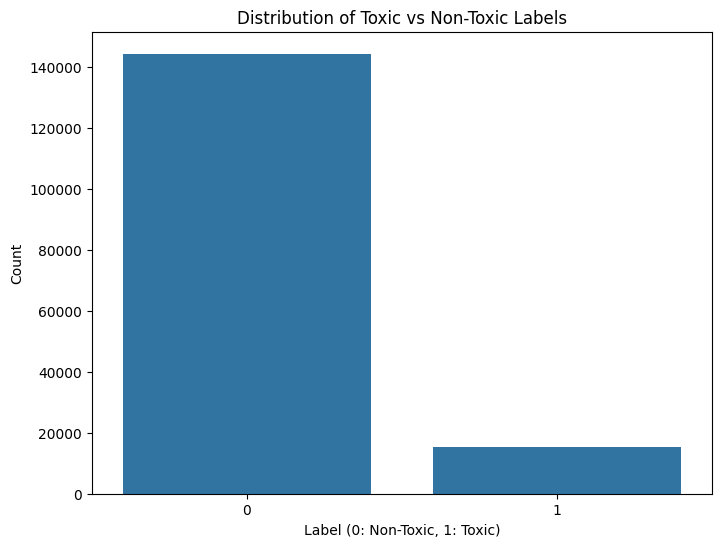

In [119]:
# Plot data distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=jigsaw_train_df['label'])
plt.title("Distribution of Toxic vs Non-Toxic Labels")
plt.xlabel("Label (0: Non-Toxic, 1: Toxic)")
plt.ylabel("Count")
plt.show()

In [120]:
# Add word count column
jigsaw_train_df['word_count'] = jigsaw_train_df['comment_text'].apply(lambda x: len(x.split()))

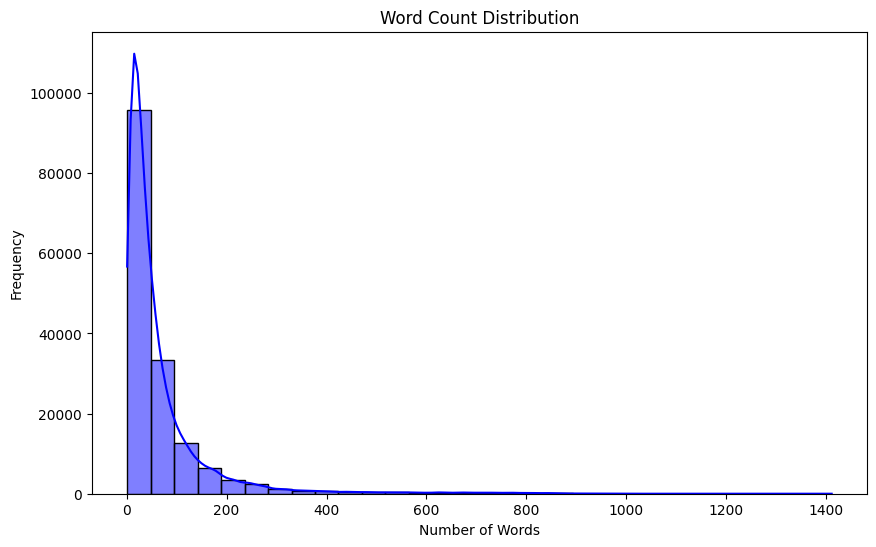

In [121]:
# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(jigsaw_train_df['word_count'], bins=30, kde=True, color='blue')
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [122]:
# Token length calculation
token_lengths = [len(tokenizer.encode(text, truncation=True)) for text in jigsaw_train_df['comment_text']]

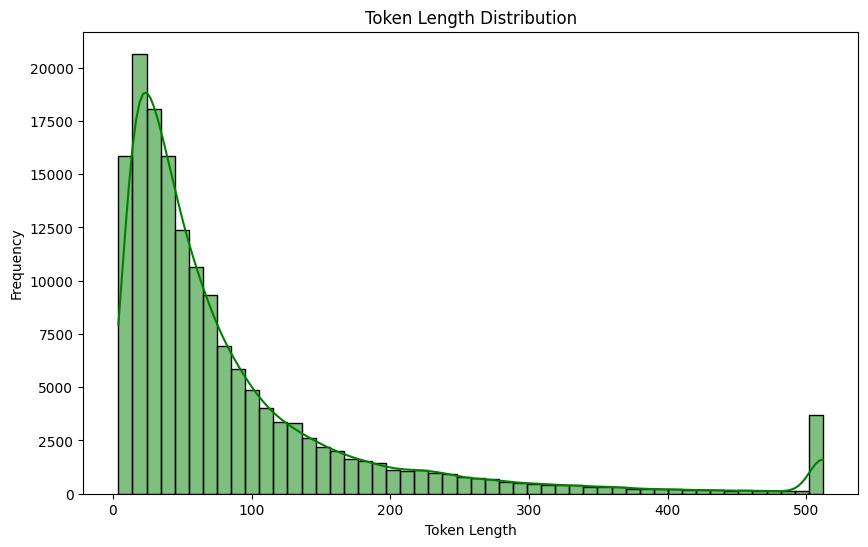

In [123]:
# Plot token length distribution
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=50, kde=True, color='green')
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

In [124]:
# Sample training logs (replace with your own logs)
training_logs = {
    'epoch': [1, 2, 3],
    'training_loss': [0.50, 0.35, 0.25],
    'validation_loss': [0.48, 0.38, 0.30],
    'accuracy': [0.80, 0.85, 0.88]
}


In [125]:
logs_df = pd.DataFrame(training_logs)

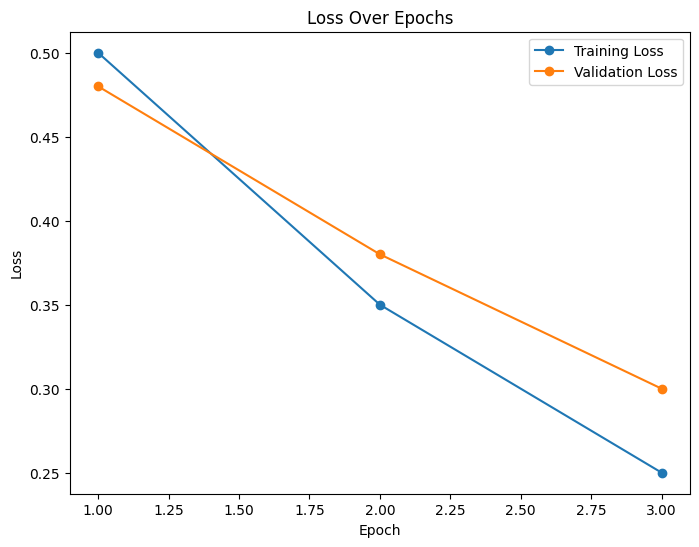

In [126]:
# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(logs_df['epoch'], logs_df['training_loss'], label="Training Loss", marker='o')
plt.plot(logs_df['epoch'], logs_df['validation_loss'], label="Validation Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

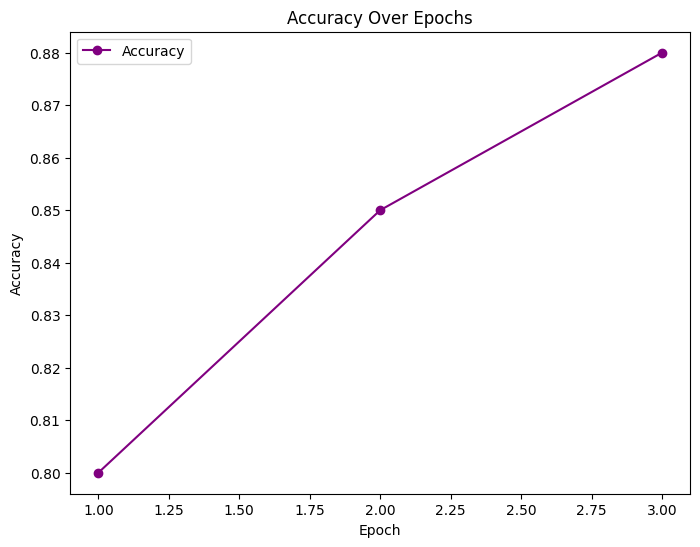

In [127]:
# Plot accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(logs_df['epoch'], logs_df['accuracy'], label="Accuracy", marker='o', color='purple')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()